In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
from scipy import fftpack


In [2]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\map'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\map\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')


In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [4]:
folder_ts = r'Data\Datasets\amz\ts'



In [5]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_ts, dataset + '.nc'))
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    #ds = ds.groupby('Region').mean()
    ds_dict[datasets_names[i]] = ds

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [6]:
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl').drop_duplicates(subset=['Code'])
df_stat = df_stat.merge(stations[['Code','Region', 'geometry']], on='Code').rename(columns={'Total':'pr'})
data = df_stat[['geometry',  'pr']].copy()
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'pr'

In [7]:
pixel_dict = {}

for name in datasets_names:
    ds = ds_dict[name].copy()

    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values

    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)

    # Step 3: Compute the mean value for each grid cell and each year
    grid_cells = data.groupby([ 'lat_bin', 'lon_bin'])[var].mean().reset_index()

    # Step 4: Create an empty DataArray with NaN values
    empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)

    # Step 5: Fill the DataArray with the computed mean values for each year
    for _, row in grid_cells.iterrows():
        #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
        lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
        lat_idx, lon_idx = int(lat_idx), int(lon_idx)

        empty_grid[lat_idx - 1, lon_idx - 1] = row[var]

    # Step 6: Create an xarray DataArray from the result with the year dimension
    #year_coords = data['year'].unique()
    data_array = xr.DataArray(empty_grid,
                                dims=('lat', 'lon'),
                                coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
    
    data_array = data_array.to_dataset(name=var)
    data_array['Region'] = ds['Region']
    #ds['stat'] = data_array
    pixel_dict[name] = ds.where(data_array.pr>= 0)


In [8]:
df = pd.DataFrame()
for name in datasets_names:
    dff =  pixel_dict[name].groupby('Region').mean().to_dataframe().dropna().reset_index()
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['time','pr', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df['time'] = df.time.astype(str)
#from time column to datetime with date and hour
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
#time to Date rename
df = df.rename(columns={'time':'Date'})


C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\3509181731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\3509181731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\3509181731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\3509181731.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\3509181731.py:5: FutureWarning: The frame.append method is dep

In [9]:
stations = gpd.read_file(r'Data\Evaluation\stations_amz_ANA.geojson')
df_stat= pd.read_pickle(r'Data\Evaluation\amz_01_20_20bet.pkl')
df_stat = df_stat.merge(stations[['Code','Region']], on='Code')
df_stat =  df_stat.groupby(['Region','Date']).mean().reset_index().drop('Code', axis=1).rename(columns={'Total':'pr'})
df_stat['Dataset'] = 'Stations'
df = df.append(df_stat)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

C:\Users\luisg\AppData\Local\Temp\ipykernel_18896\2312179143.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_stat)


In [10]:
#fast fourier for each dataset in df, and create a df with the results
df_fft = pd.DataFrame()
for region in df.Region.unique():
    df_region = df[df.Region == region]
    for dataset in df.Dataset.unique():
        df_dataset = df_region[df_region.Dataset == dataset]
        df_dataset_fft = fftpack.fft(df_dataset[df_dataset.Dataset == dataset].pr.values)
        #power spectrum
        power = np.abs(df_dataset_fft)
        #sample frequencies
        sample_freq = fftpack.fftfreq(df_dataset[df_dataset.Dataset == dataset].pr.size, d=1)
        #only positive frequencies
        pos_mask = np.where(sample_freq > 0)
        freqs = sample_freq[pos_mask]
        peak_freq = freqs[power[pos_mask].argmax()]
        #save results in df_fft
        dff = pd.DataFrame({ 'power': power,'freqs': sample_freq})
        dff['Dataset'] = dataset
        dff['Region'] = region
        df_fft = pd.concat([df_fft, dff])

#create period column 
df_fft['period'] = 1 / df_fft.freqs/12
#only positive frequencies
df_fft = df_fft[df_fft.freqs > 0]
df_fft = df_fft[df_fft.period > 1]
df_fft['power'] = df_fft['power']/240

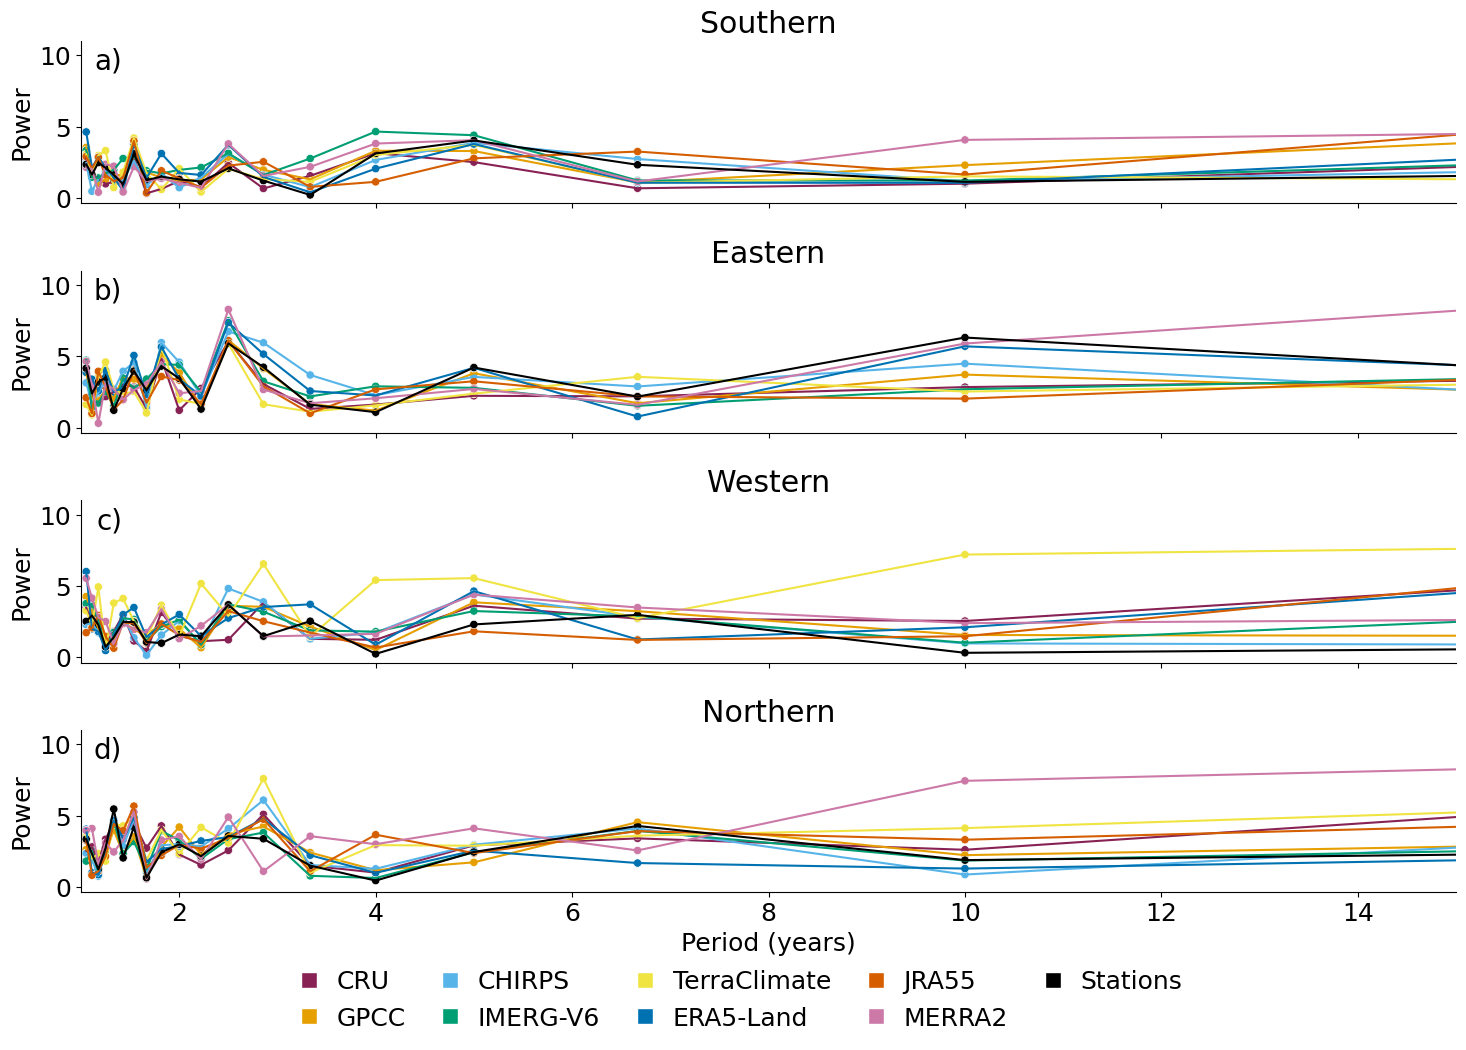

In [11]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex='col', sharey='col')
plt.rcParams.update({'font.size': 18})
letters_ts = ['a)', 'b)', 'c)', 'd)']
for i, region in enumerate(df_fft.Region.unique()):
    df_region = df[df.Region == region]
    df_fft_region = df_fft[df_fft.Region == region]
    sns.scatterplot(data=df_fft_region, x='period', y='power', hue='Dataset', ax=axes[i], hue_order=hue_order, palette=wong_b)
    sns.lineplot(data=df_fft_region, x='period', y='power', hue='Dataset', ax=axes[i], legend=False, hue_order=hue_order, palette=wong_b)
    # ylabel from the first column as region
    axes[i].set_title(region)
#delete all but the last axis legend
    axes[i].get_legend().remove()
    axes[i].set_ylabel('Power')
    #set x axis as log
    #axes[i].set_xscale('log')
    axes[i].text(0.03,0.96,  letters_ts[i], transform=axes[i].transAxes,  fontsize=20, va='top', ha='right')
    #despine
    sns.despine()
axes[0].set_xlim(1, 15)
axes[3].set_xlabel('Period (years)')
fig.legend(handles=legend_elements_b, bbox_to_anchor=(0.5, -0.07), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)
plt.tight_layout()